This is known as neural style transfer and the technique is outlined in [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

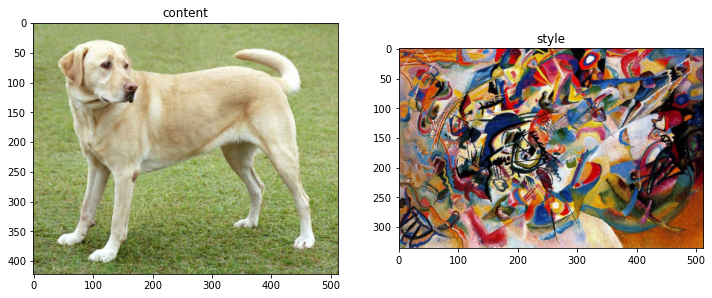

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# get the images
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  
  new_shape = tf.cast(shape * scale, tf.int32)
  
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  if title:
    plt.title(title)
    

content_img = load_img(content_path)
style_img = load_img(style_path)

plt.subplot(1,2,1);
imshow(content_img, 'content')
plt.subplot(1,2,2);
imshow(style_img, 'style')



In [2]:
#content_img
tf.constant(content_img)

<tf.Tensor: shape=(1, 422, 512, 3), dtype=float32, numpy=
array([[[[0.6290779 , 0.64868575, 0.38986227],
         [0.6007131 , 0.62248087, 0.3679772 ],
         [0.5896757 , 0.61320513, 0.3622247 ],
         ...,
         [0.5269978 , 0.55837035, 0.32699776],
         [0.49909076, 0.5304633 , 0.29732907],
         [0.47968566, 0.5110583 , 0.27576408]],

        [[0.6060711 , 0.6300001 , 0.36901602],
         [0.60180223, 0.62551117, 0.3700369 ],
         [0.6003996 , 0.623929  , 0.37294865],
         ...,
         [0.52357244, 0.554945  , 0.32141185],
         [0.5284101 , 0.5597826 , 0.3254584 ],
         [0.53133637, 0.5627089 , 0.3274148 ]],

        [[0.58011585, 0.60756683, 0.3448217 ],
         [0.5973071 , 0.6225982 , 0.36633283],
         [0.60061604, 0.6340622 , 0.3797762 ],
         ...,
         [0.530031  , 0.5614036 , 0.32610947],
         [0.5510388 , 0.58241135, 0.34711725],
         [0.55976367, 0.5911362 , 0.35584208]],

        ...,

        [[0.43124956, 0.40153953, 

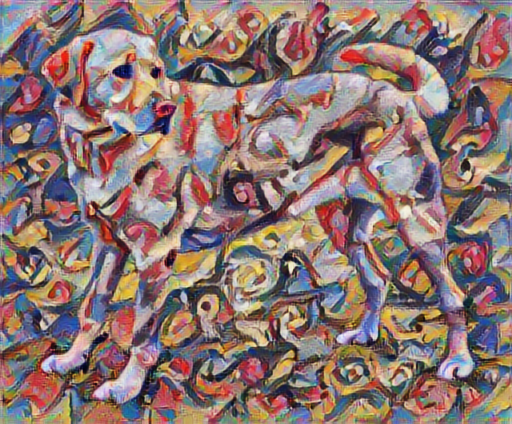

In [3]:
## Fast transfer using TF-Hub
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_img), tf.constant(style_img))[0]
tensor_to_image(stylized_image)

In [4]:
## Load a VGG19 dataset and test run it on our image
x = tf.keras.applications.vgg19.preprocess_input(content_img*255)
x = tf.image.resize(x,(224,224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
#vgg.summary()
prediction_probabilities = vgg(x)
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
len(predicted_top_5)
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

# now without the classification head
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

vgg.summary()

TensorShape([1, 1000])

5

[('Labrador_retriever', 0.4931724),
 ('golden_retriever', 0.23665221),
 ('kuvasz', 0.036357228),
 ('Chesapeake_Bay_retriever', 0.024182763),
 ('Greater_Swiss_Mountain_dog', 0.018646047)]

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [5]:
# choose intermediate layers from the network to represent style and content of the image
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
  """Creates a vgg model that returns a list of intermediate output values."""
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_img*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(f"{name} shape: {output.numpy().shape}  min: {output.numpy().min()}  max: {output.numpy().max()}  mean: {output.numpy().mean()}")


block1_conv1 shape: (1, 336, 512, 64)  min: 0.0  max: 835.5255126953125  mean: 33.975250244140625
block2_conv1 shape: (1, 168, 256, 128)  min: 0.0  max: 4625.88671875  mean: 199.82687377929688
block3_conv1 shape: (1, 84, 128, 256)  min: 0.0  max: 8789.2412109375  mean: 230.78103637695312
block4_conv1 shape: (1, 42, 64, 512)  min: 0.0  max: 21566.13671875  mean: 791.2400512695312
block5_conv1 shape: (1, 21, 32, 512)  min: 0.0  max: 3189.253662109375  mean: 59.17947769165039


In [6]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  #print(f"{input_tensor.shape} ... {result.shape}")

  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
    
  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs] 
    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
    return {'content':content_dict, 'style': style_dict}
  
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_img))

style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']


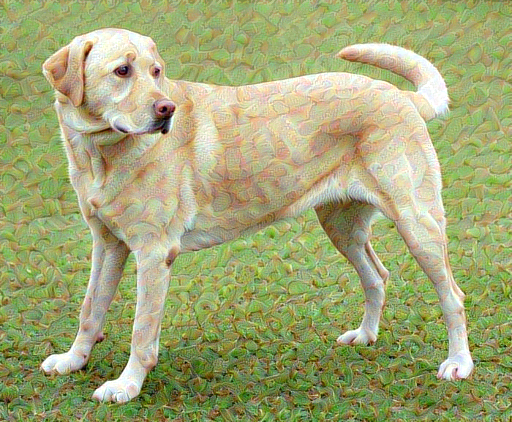

In [7]:
# define a variable to contain the image to optimize
image = tf.Variable(content_img)

# define a function to keep the pixel values between 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
# to optimize use a weighted combination of the two losses to get the total loss
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                        for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers
  
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                          for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [8]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
  print(f"Step: {step}")
  
end = time.time()
print(f"Total time: {end-start:.1f}")

Step: 100
Step: 200
Step: 300
Step: 400
Step: 500
Step: 600
Step: 700
Step: 800
Step: 900
Step: 1000
Total time: 743.5


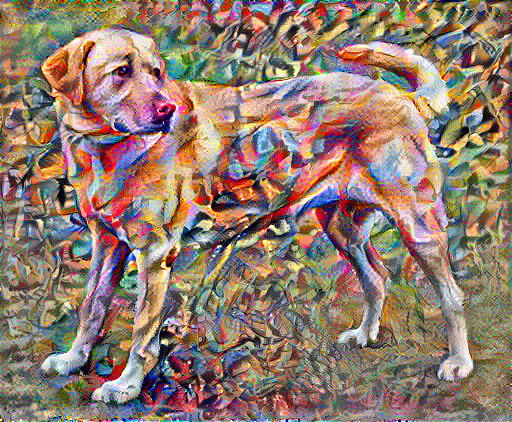

In [9]:
tensor_to_image(image)

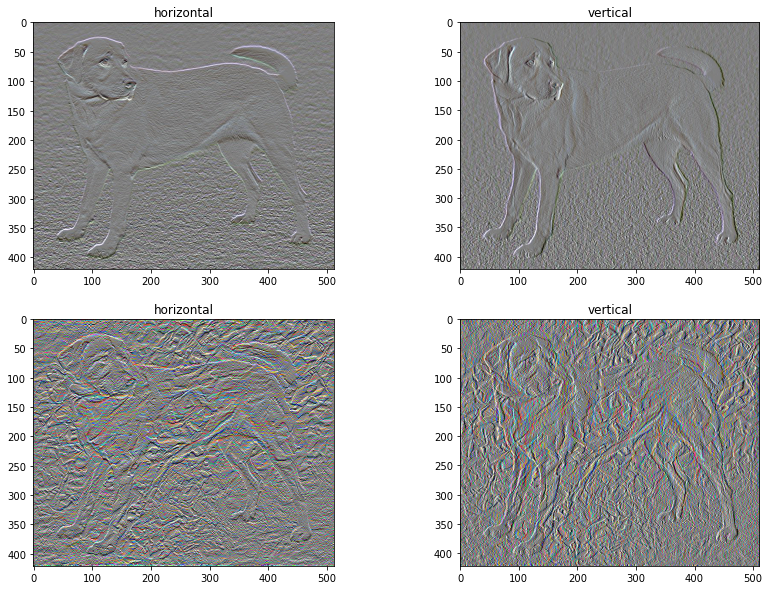

In [10]:
## reduce the high frequency artifacts
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]
  return x_var, y_var

x_var, y_var = high_pass_x_y(content_img)
plt.figure(figsize=(14,10));
plt.subplot(2,2,1);
imshow(clip_0_1(2*y_var+0.5), "horizontal");
plt.subplot(2,2,2);
imshow(clip_0_1(2*x_var+0.5), "vertical");

x_var, y_var = high_pass_x_y(image)
plt.subplot(2,2,3);
imshow(clip_0_1(2*y_var+0.5), "horizontal");
plt.subplot(2,2,4);
imshow(clip_0_1(2*x_var+0.5), "vertical");

In [11]:
## add a total variation loss
tf.image.total_variation(image).numpy()

## Train with total variation loss
total_variation_weight = 30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * tf.image.total_variation(image)
  
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
  print(f"Step: {step}")
  
end = time.time()
print(f"Total time: {end-start:.1f}")

array([149374.25], dtype=float32)

Step: 100
Step: 200
Step: 300
Step: 400
Step: 500
Step: 600
Step: 700
Step: 800
Step: 900
Step: 1000
Total time: 738.0


In [12]:
## Save the final image
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)
